- [Blog - Part 1](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)

In [1]:
%matplotlib inline
import numpy as np
import gym
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
env = gym.make("FrozenLake-v0")

[2017-07-06 17:07:34,714] Making new env: FrozenLake-v0


In [3]:
env.observation_space.n # the number of states

16

In [4]:
env.action_space.n

4

In [5]:
print(np.random.randn.__doc__)


        randn(d0, d1, ..., dn)

        Return a sample (or samples) from the "standard normal" distribution.

        If positive, int_like or int-convertible arguments are provided,
        `randn` generates an array of shape ``(d0, d1, ..., dn)``, filled
        with random floats sampled from a univariate "normal" (Gaussian)
        distribution of mean 0 and variance 1 (if any of the :math:`d_i` are
        floats, they are first converted to integers by truncation). A single
        float randomly sampled from the distribution is returned if no
        argument is provided.

        This is a convenience function.  If you want an interface that takes a
        tuple as the first argument, use `numpy.random.standard_normal` instead.

        Parameters
        ----------
        d0, d1, ..., dn : int, optional
            The dimensions of the returned array, should be all positive.
            If no argument is given a single Python float is returned.

        Returns
        --

In [6]:
print(env.step.__doc__)

Run one timestep of the environment's dynamics. When end of
        episode is reached, you are responsible for calling `reset()`
        to reset this environment's state.

        Accepts an action and returns a tuple (observation, reward, done, info).

        Args:
            action (object): an action provided by the environment

        Returns:
            observation (object): agent's observation of the current environment
            reward (float) : amount of reward returned after previous action
            done (boolean): whether the episode has ended, in which case further step() calls will return undefined results
            info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
        


In [19]:
learn_rate = 0.85
disc_rate = 0.99
num_episodes = 2000
iters_per_episode = 100
failure_penalty = -0.05

Q = np.zeros((env.observation_space.n, env.action_space.n))
rewards = []
sucesses = []
for episode in range(num_episodes):
    s_current = env.reset()
    acc_reward = 0
    is_doomed = False
    
    for _ in range(iters_per_episode):
        # here we decrease the noise for later episodes in order to have a converge result
        action = np.argmax(Q[s_current] + np.random.randn(1, env.action_space.n)*(1/(episode+1)))
        s_next, reward, is_doomed, _ = env.step(action)
        reward = is_doomed and [failure_penalty, reward][reward > 0] or reward
        Q[s_current, action] = Q[s_current, action] + learn_rate*(reward + disc_rate*np.max(Q[s_next] - Q[s_current, action]))
        acc_reward += reward
        s_current = s_next
        if is_doomed:
            sucesses.append([0, 1][reward > 0])
            break
    rewards.append(acc_reward)

In [20]:
print("Average rewards (over episodes): {:02f}".format(sum(rewards)/num_episodes))
print("Q-table:\n", Q)

Average rewards (over episodes): 0.500725
Q-table:
 [[ 0.00699344  0.04532078  0.81485432  0.00381289]
 [-0.05030395 -0.03479689 -0.04250425  0.73315728]
 [-0.01996727 -0.00664328 -0.03666222  0.69130041]
 [-0.0435677  -0.03715872 -0.03774145  0.68875786]
 [ 0.91467926 -0.04253118 -0.0348479  -0.04923625]
 [ 0.          0.          0.          0.        ]
 [ 0.59354307 -0.05033077 -0.05004926 -0.05047318]
 [ 0.          0.          0.          0.        ]
 [-0.0425     -0.0410803  -0.04238497  0.95522344]
 [-0.0425      0.98082017 -0.0425     -0.04058923]
 [ 0.24033185 -0.04433941 -0.04804782 -0.04831096]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.0425     -0.0055621   1.0044509  -0.0425    ]
 [ 0.          1.00977194  0.          0.        ]
 [ 0.          0.          0.          0.        ]]


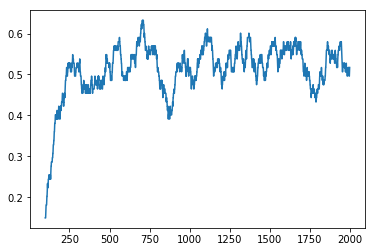

In [21]:
plt.plot(pd.Series(rewards).rolling(window=100).mean())

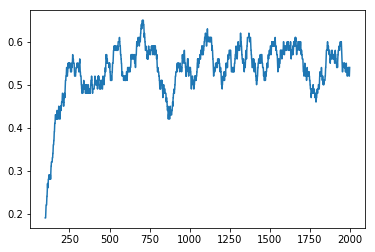

In [22]:
plt.plot(pd.Series(sucesses).rolling(window=100).mean())

## Q-Learning with NN

key idea: Replace table with a neural network which takes state as input and produce a Q-value.

$$
Loss = \sum(Q_{target} - Q)^2
$$

In [11]:
import tensorflow as tf

Implementing NN

In [12]:
tf.reset_default_graph()

In [13]:
input_layer = tf.placeholder(shape=[1, 16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16, 4], 0, 0.01))
Q_out = tf.matmul(input_layer, W)
prediction = tf.argmax(Q_out, axis=1)

Q_target = tf.placeholder(shape=[1, 4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(Q_target - Q_out))
train = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

Training NN

In [14]:
disc_rate = 0.99
num_episodes = 2000
iters_per_episode = 100
stop_iterations = []
acc_rewards = []
err_rates = []

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print("All variables initialized")
    
    for episode in range(num_episodes):
        s_current = env.reset()
        is_doomed = False
        acc_reward = 0
        # If you play with err_rate a bit, 
        # you'll find out that this is very important for the training of the Q-learning NN.
        # If err_rate goes down too quickly or with small initial value, 
        # your NN will not learn much about the Q-table
        # since it stuck in local greedy strategy (no exploration)
        err_rate = 1.0/((episode/50.0) + 10.0)
        
        for iteration in range(iters_per_episode):
            action, Q_predict = sess.run([prediction, Q_out], 
                                         feed_dict={input_layer:np.identity(env.observation_space.n)[s_current:s_current+1]})
            action = action[0]
            if np.random.rand(1) < err_rate:
                action = env.action_space.sample()
            s_next, reward, is_doomed, _ = env.step(action)
            
            Q_next = sess.run(Q_out, feed_dict={input_layer:np.identity(env.observation_space.n)[s_next:s_next+1]})
            max_Q_next = np.max(Q_next)
            Q_predict[0, action] = reward + disc_rate*max_Q_next
            _ = sess.run([train], 
                         feed_dict={input_layer:np.identity(env.observation_space.n)[s_current:s_current+1], 
                                    Q_target:Q_predict})
            acc_reward += reward
            s_current = s_next
            if is_doomed:
                err_rates.append(err_rate)
                break
        stop_iterations.append(iteration)
        acc_rewards.append(acc_reward)

All variables initialized


In [15]:
print("percentage of successful episodes: {}%".format(sum(acc_rewards)/num_episodes))

percentage of successful episodes: 0.0695%


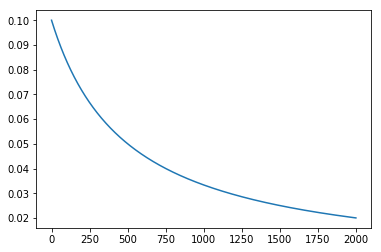

In [16]:
plt.plot(err_rates)

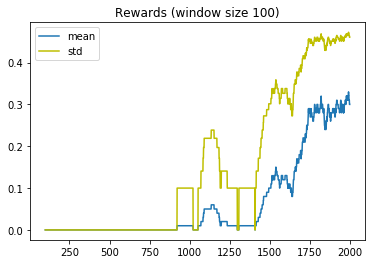

In [17]:
# mean accumulated awards
plt.title("Rewards (window size 100)")
line_mean, =plt.plot(pd.Series(acc_rewards).rolling(window=100, center=False).mean(), '-')
line_std, = plt.plot(pd.Series(acc_rewards).rolling(window=100).std(), '-y')
plt.legend([line_mean, line_std], ["mean", "std"])

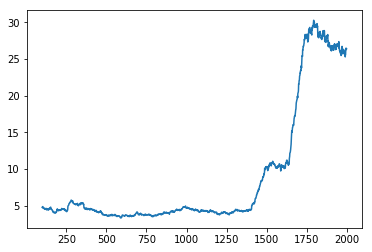

In [18]:
plt.plot(pd.Series(stop_iterations).rolling(window=100).mean())